In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
import os
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# モデルの定義
class Encoder(nn.Module):
    def __init__(self, latent_size, image_size):
        super(Encoder, self).__init__()
        self.H = int(image_size / 4)  # ダウンサンプリングされるサイズ
        self.W = int(image_size / 4)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.linear1 = nn.Linear(128 * self.H * self.W, 64)
        self.linear2 = nn.Linear(64, latent_size)  # 潜在変数の次元を1に変更
        self.linear3 = nn.Linear(64, latent_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.shape[0], -1)  # Flatten
        x = F.relu(self.linear1(x))
        z_mean = self.linear2(x)
        z_log_var = self.linear3(x)
        return z_mean, z_log_var

    def sampling(self, z_mean, z_log_var):
        epsilon = torch.randn(z_mean.shape, device=z_mean.device)
        return z_mean + epsilon * torch.exp(0.5 * z_log_var)

class Decoder(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.H = int(image_size / 4)
        self.W = int(image_size / 4)
        self.to_shape = (128, self.H, self.W)
        self.linear = nn.Linear(latent_size, 128 * self.H * self.W)  # 潜在サイズを1に変更
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.linear(x))
        x = x.view(-1, *self.to_shape)  # Reshape to (batch, C, H, W)
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))
        return x

class VAE(nn.Module):
    def __init__(self, latent_size, image_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_size, image_size)
        self.decoder = Decoder(image_size)

    def forward(self, x, C=1.0, k=1):
        z_mean, z_log_var = self.encoder(x)

        rec_loss = 0
        for _ in range(k):
            z = self.encoder.sampling(z_mean, z_log_var)
            y = self.decoder(z)
            rec_loss += F.binary_cross_entropy(torch.flatten(y, start_dim=1), torch.flatten(x, start_dim=1)) / k

        kl_loss = C * (z_mean ** 2 + torch.exp(z_log_var) - z_log_var - 1) * 0.5
        kl_loss = torch.sum(kl_loss) / len(x)
        return rec_loss + kl_loss

/var/folders/1f/9sw91vb56l9dpgy8zb1m887w0000gn/T/ipykernel_1857/3099982858.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_paths[

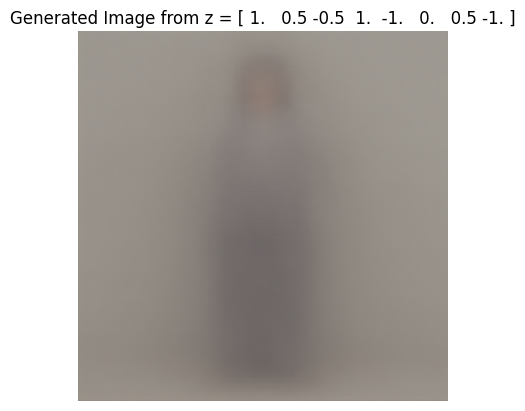

In [2]:
import torch
import matplotlib.pyplot as plt
import os

# 各モデルのロード
models = []
latent_size = 1  # 各モデルの潜在変数の次元
image_size = 276  # 画像サイズ
device = torch.device("cpu")

# モデルが保存されているディレクトリのパス
model_directory = "/Volumes/public/Document/Python/VAE/data3/models"

# ディレクトリ内の全てのファイルパスを取得
model_paths = [os.path.join(model_directory, filename) for filename in os.listdir(model_directory) if os.path.isfile(os.path.join(model_directory, filename))]


for i in range(8):
    model = VAE(latent_size=latent_size, image_size=image_size).to(device)
    model.load_state_dict(torch.load(model_paths[i], map_location=device))
    model.eval()
    models.append(model)

def generate_combined_image(models, z_values):
    # z_valuesをTensorに変換
    z_values = torch.tensor(z_values, dtype=torch.float32).to(device)

    # 各モデルのデコーダを使って画像を生成
    with torch.no_grad():
        generated_images = []
        for i in range(len(models)):
            img = models[i].decoder(z_values[i].view(1, -1)).cpu().numpy()
            generated_images.append(img)

    # 画像を平均して結合
    combined_img = np.mean(generated_images, axis=0)

    # 画像の形状を (276, 276, 3) に変換
    combined_img = combined_img[0].transpose(1, 2, 0)

    # 生成された画像を表示
    plt.imshow(combined_img)
    plt.title(f'Generated Image from z = {z_values.cpu().numpy()}')
    plt.axis('off')
    plt.show()

# 潜在変数の値を指定
z_values = [1.0, 0.5, -0.5, 1.0, -1.0, 0.0, 0.5, -1.0]  # 8次元の潜在変数
generate_combined_image(models, z_values)

/var/folders/1f/9sw91vb56l9dpgy8zb1m887w0000gn/T/ipykernel_1857/1620278643.py:25: UserWarning: Glyph 12454 (\N{KATAKANA LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1f/9sw91vb56l9dpgy8zb1m887w0000gn/T/ipykernel_1857/1620278643.py:25: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1f/9sw91vb56l9dpgy8zb1m887w0000gn/T/ipykernel_1857/1620278643.py:25: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1f/9sw91vb56l9dpgy8zb1m887w0000gn/T/ipykernel_1857/1620278643.py:25: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1f/9sw91vb56l9dpgy8zb1m887w0000gn/T/ipykernel_1857/1620278643.py:25: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1f/9sw91vb56l9dpgy8zb1m887w0000gn/T/ipykernel_1857/16

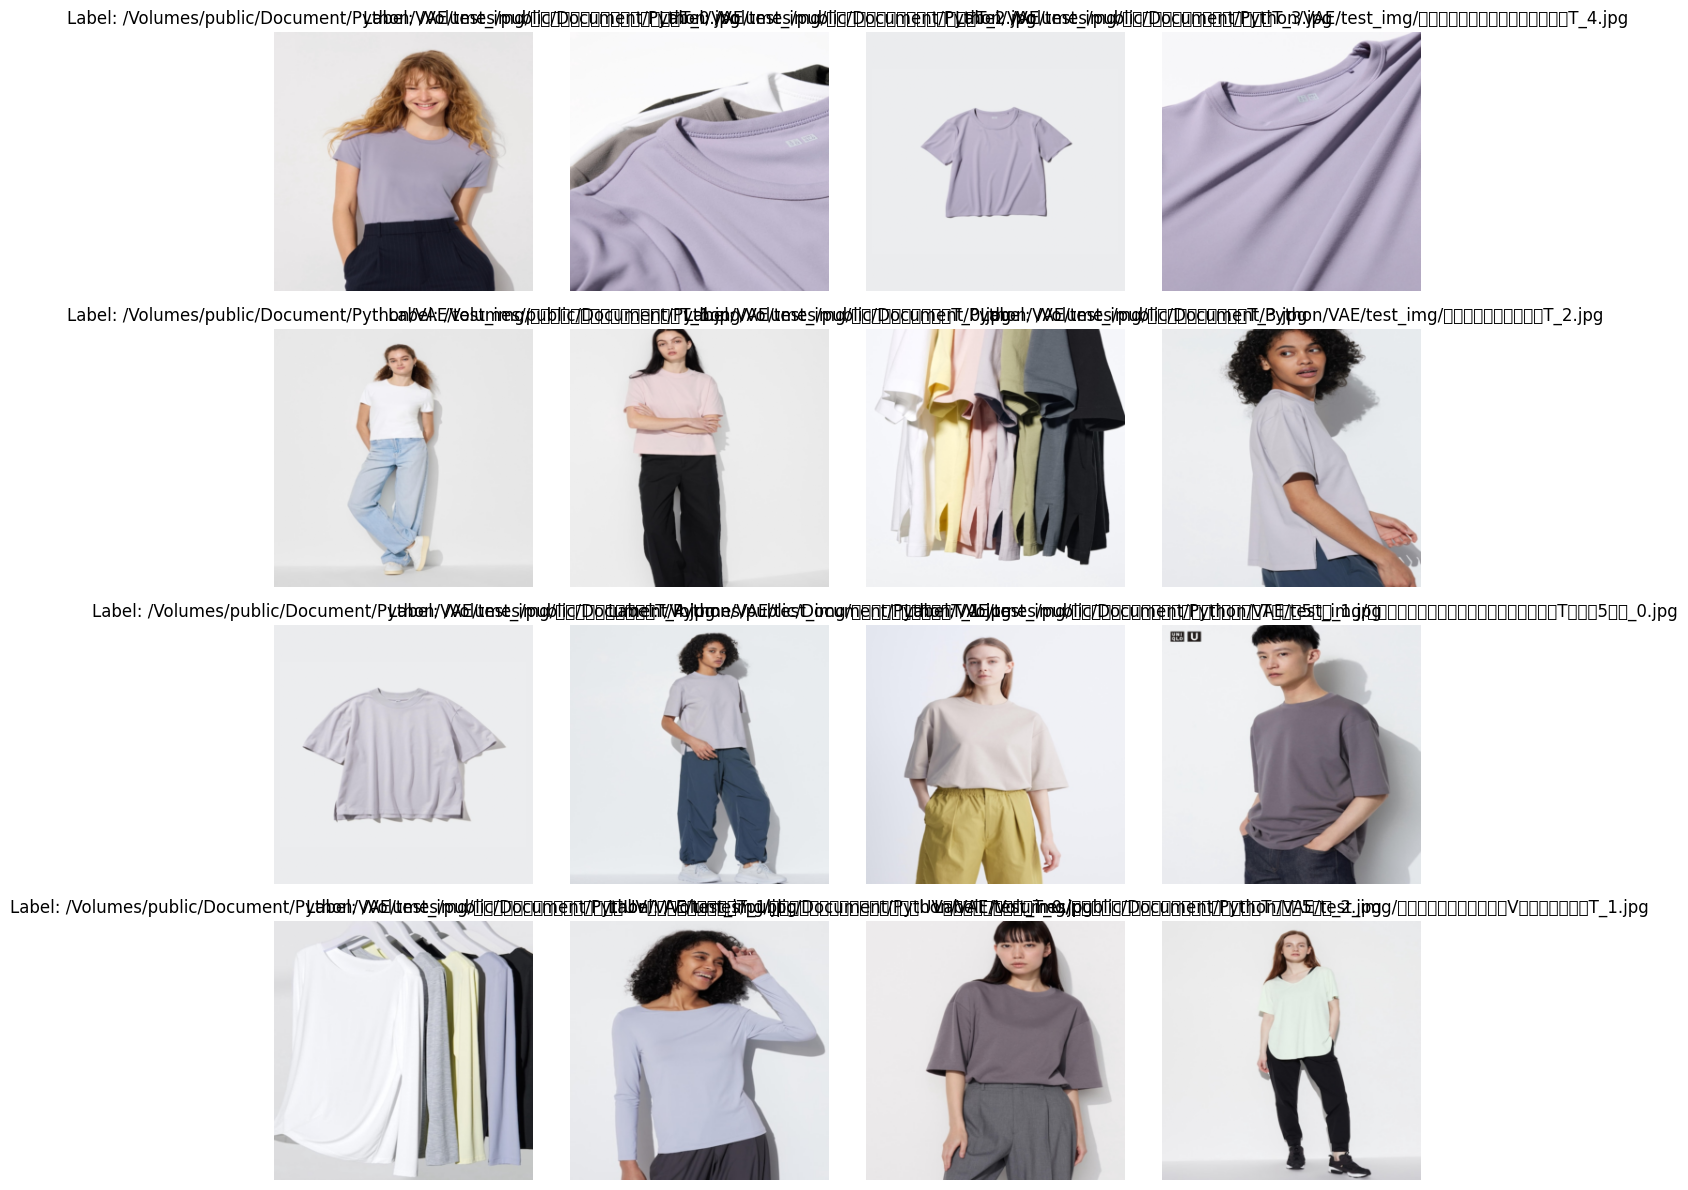

Loaded 131 images


In [3]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# 各設定値
img_height = 276  # 画像の幅
img_width = 276   # 画像の高さ
batch_size = 10

# 可視化関数
def visualize_dataset(dataset, num_images=16):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(num_images):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Label: {label}')

    plt.tight_layout()
    plt.show()

# 画像ファイルが有効かどうかをチェックする関数
def is_valid_image_file(filepath):
    try:
        with Image.open(filepath) as img:
            img.verify()  # 画像として有効か確認
        return True
    except (UnidentifiedImageError, OSError):
        return False

# モデルが保存されているディレクトリのパス
model_directory = "/Volumes/public/Document/Python/VAE/test_img"

# ディレクトリ内の全てのファイルパスを取得
img_paths = [os.path.join(model_directory, filename) for filename in os.listdir(model_directory) if os.path.isfile(os.path.join(model_directory, filename))]


# データセットクラスの定義
class CustomImageDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform
        self.image_paths = [p for p in img_paths if is_valid_image_file(p)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = img_path  # ラベルとして画像パスを返す（必要に応じて変更可能）
        return img, label

# 画像データの前処理
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

# データセットとデータローダーの作成
dataset = CustomImageDataset(img_paths=img_paths, transform=transform)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# データセットの可視化
visualize_dataset(dataset, num_images=16)
print(f"Loaded {len(dataset)} images")

In [4]:
# 学習設定
latent_size = 1  # 潜在空間の次元を1に設定
image_size = 276

device = torch.device("cpu")
model = VAE(latent_size=latent_size, image_size=image_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

/var/folders/1f/9sw91vb56l9dpgy8zb1m887w0000gn/T/ipykernel_1857/3587511885.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_paths[

潜在変数: [array([[0.05783652]], dtype=float32), array([[0.00396849]], dtype=float32), array([[0.20823547]], dtype=float32), array([[-1.239979]], dtype=float32), array([[-0.51625437]], dtype=float32), array([[0.9920063]], dtype=float32), array([[-0.9769691]], dtype=float32), array([[-1.4122709]], dtype=float32)]
各系統の強さ（絶対値）: [0.05783652 0.00396849 0.20823547 1.239979   0.51625437 0.9920063
 0.9769691  1.4122709 ]
平均強さ: 0.67594004
強さのばらつき（標準偏差）: 0.5158348
VAE_ModeMass の強さ: 0.057836517691612244
VAE_SportKorea の強さ: 0.0039684888906776905
VEA_StreetNatural の強さ: 0.2082354724407196
VAE_OutdoorNormcore の強さ: 1.2399790287017822
VAE_EleganceTrad の強さ: 0.5162543654441833
VAE_GirlyDesigner の強さ: 0.9920063018798828
VAE_OfficeManush の強さ: 0.9769691228866577
元の画像の形状: torch.Size([3, 276, 276])


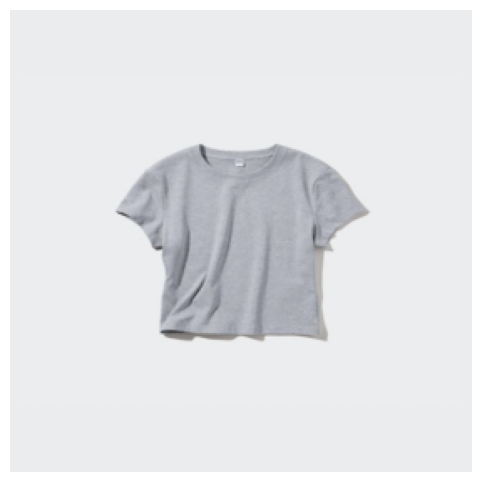

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# 各モデルのロード
models = []
latent_size = 1  # 各モデルの潜在変数の次元
image_size = 276  # 画像サイズ
device = torch.device("cpu")

# モデルが保存されているディレクトリのパス
model_directory = "/Volumes/public/Document/Python/VAE/data3/models"

# ディレクトリ内の全てのファイルパスを取得
model_paths = [os.path.join(model_directory, filename) for filename in os.listdir(model_directory) if os.path.isfile(os.path.join(model_directory, filename))]

for i in range(8):
    model = VAE(latent_size=latent_size, image_size=image_size).to(device)
    model.load_state_dict(torch.load(model_paths[i], map_location=device))
    model.eval()
    models.append(model)

def predict_latent_variables(models, input_data):
    # 入力データをTensorに変換し、形状を調整（バッチサイズ、チャンネル、高さ、幅）
    input_data = torch.tensor(input_data, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)  # (1, 3, 276, 276)

    # 各モデルのエンコーダを使って潜在変数を予測
    latent_variables = []
    with torch.no_grad():
        for model in models:
            z_mean, z_log_var = model.encoder(input_data)  # エンコーダに入力
            std = torch.exp(0.5 * z_log_var)  # 標準偏差を計算
            epsilon = torch.randn_like(std)  # 標準正規分布からのランダムな値を生成
            z = z_mean + epsilon * std  # 潜在変数を計算
            latent_variables.append(z.cpu().numpy())  # 潜在変数を取得してCPUに移動

    return latent_variables

def plot_latent_space(latent_variables):
    # 潜在変数を可視化
    latent_variables = np.array(latent_variables)
    plt.scatter(latent_variables, np.zeros_like(latent_variables), c='blue', label='Latent Variable Positions')
    plt.xlabel('Latent Variable')
    plt.yticks([])
    plt.title('Latent Variable Positions in Latent Space')
    plt.axhline(0, color='grey', lw=0.5, ls='--')
    plt.legend()
    plt.show()

num = 100
# データセットから画像を取得
img, _ = dataset[num]  # datasetは事前に定義されている必要があります

# 画像をバッチサイズ1のテンソルに変換
img = img.unsqueeze(0)  # (C, H, W) -> (1, C, H, W)

# 潜在変数を取得するために、入力データを予測関数に渡す
latent_variables = predict_latent_variables(models, img[0].permute(1, 2, 0).numpy())  # (C, H, W) -> (H, W, C)

# 潜在変数の値を表示
print("潜在変数:", latent_variables)

# 絶対値を取り出してフラットな配列に
latent_vals = np.array([abs(var[0][0]) for var in latent_variables])

# 平均・分散を計算
mean_strength = np.mean(latent_vals)
std_dev_strength = np.std(latent_vals)

# 結果表示
print("各系統の強さ（絶対値）:", latent_vals)
print("平均強さ:", mean_strength)
print("強さのばらつき（標準偏差）:", std_dev_strength)

# 系統名と一緒に表示
model_names = [
    "VAE_ModeMass", "VAE_SportKorea", "VEA_StreetNatural", "VAE_OutdoorNormcore",
    "VAE_EleganceTrad", "VAE_GirlyDesigner", "VAE_OfficeManush"
]

for name, strength in zip(model_names, latent_vals):
    print(f"{name} の強さ: {strength}")
# データセットから画像を取得
img_show, _ = dataset[num]
print("元の画像の形状:", img_show.shape)

# (C, H, W) -> (H, W, C) に変換
input_data = img_show.permute(1, 2, 0).numpy()

# 1枚だけ表示する
plt.figure(figsize=(6, 6))  # 図のサイズを設定
plt.imshow(img_show.permute(1, 2, 0))  # 元の画像を表示
plt.axis('off')  # 軸を表示しない
plt.show()

ユニクロの商品の名前を取得しデータフレームでまとめ、予測する

In [6]:
import os

# モデルが保存されているディレクトリのパス
model_directory = "/Volumes/public/Document/Python/VAE/test_img"

# ディレクトリ内の全てのファイルパスを取得
img_paths = [os.path.join(model_directory, filename) for filename in os.listdir(model_directory) if os.path.isfile(os.path.join(model_directory, filename))]

# 取得したファイルパスを出力
for path in img_paths:
    print(path)
print(len(img_paths))

/Volumes/public/Document/Python/VAE/test_img/ウルトラストレッチエアリズムT_0.jpg
/Volumes/public/Document/Python/VAE/test_img/ウルトラストレッチエアリズムT_2.jpg
/Volumes/public/Document/Python/VAE/test_img/ウルトラストレッチエアリズムT_3.jpg
/Volumes/public/Document/Python/VAE/test_img/ウルトラストレッチエアリズムT_4.jpg
/Volumes/public/Document/Python/VAE/test_img/ウルトラストレッチエアリズムT_1.jpg
/Volumes/public/Document/Python/VAE/test_img/エアリズムコットンT_0.jpg
/Volumes/public/Document/Python/VAE/test_img/エアリズムコットンT_3.jpg
/Volumes/public/Document/Python/VAE/test_img/エアリズムコットンT_2.jpg
/Volumes/public/Document/Python/VAE/test_img/エアリズムコットンT_4.jpg
/Volumes/public/Document/Python/VAE/test_img/エアリズムコットンT_1.jpg
/Volumes/public/Document/Python/VAE/test_img/エアリズムコットンオーバーサイズTシャツ5分袖_1.jpg
/Volumes/public/Document/Python/VAE/test_img/エアリズムコットンオーバーサイズTシャツ5分袖_0.jpg
/Volumes/public/Document/Python/VAE/test_img/エアリズムシルクブレンドUVカットクルーネックT_1.jpg
/Volumes/public/Document/Python/VAE/test_img/エアリズムシルクブレンドUVカットクルーネックT_0.jpg
/Volumes/public/Document/Python

In [7]:
# 商品名のみを取得してリストに格納
product_names = [os.path.splitext(os.path.basename(path))[0] for path in img_paths]

# 結果を出力
print(product_names)


# 商品名を格納するリスト
# product_names = []

# # 商品名を抽出してリストに追加
# for path in img_paths:
#     # ファイル名を取得し、拡張子と連番を除去
#     filename = os.path.basename(path)  # ファイル名だけ取得
#     product_name = filename.split("_")[0]  # "_"で分割して商品名だけを取得
#     product_names.append(product_name)

# # 結果を表示
# print(product_names)

['ウルトラストレッチエアリズムT_0', 'ウルトラストレッチエアリズムT_2', 'ウルトラストレッチエアリズムT_3', 'ウルトラストレッチエアリズムT_4', 'ウルトラストレッチエアリズムT_1', 'エアリズムコットンT_0', 'エアリズムコットンT_3', 'エアリズムコットンT_2', 'エアリズムコットンT_4', 'エアリズムコットンT_1', 'エアリズムコットンオーバーサイズTシャツ5分袖_1', 'エアリズムコットンオーバーサイズTシャツ5分袖_0', 'エアリズムシルクブレンドUVカットクルーネックT_1', 'エアリズムシルクブレンドUVカットクルーネックT_0', 'エアリズムコットンオーバーサイズTシャツ5分袖_2', 'エアリズムシームレスVネックロングT_1', 'エアリズムシームレスVネックロングT_3', 'エアリズムシームレスVネックロングT_0', 'エアリズムシルクブレンドUVカットクルーネックT_2', 'エアリズムシームレスVネックロングT_2', 'エアリズムシームレスVネックロングT_4', 'エアリズムドレープT_1', 'エアリズムドレープT_2', 'エアリズムドレープT_0', 'エアリズムドレープT_3', 'クルーネックT_0', 'クルーネックT_1', 'クルーネックT_2', 'クルーネックT_3', 'クルーネックT_4', 'クレープジャージーノースリーブT_0', 'クレープジャージーノースリーブT_1', 'クレープジャージーノースリーブT_2', 'クレープジャージーノースリーブT_3', 'コットンリラックスT5分袖_0', 'コットンリラックスT5分袖_1', 'コットンリラックスT5分袖_2', 'コットンリラックスT5分袖_3', 'コットンリラックスT5分袖_4', 'シャーリングT_0', 'シャーリングT_2', 'シャーリングT_3', 'シャーリングT_1', 'スムースコットンリラックスT_0', 'スムースコットンリラックスT_1', 'スムースコットンリラックスT_2', 'スムースコットンリラックスT_3', 'スム

In [8]:
import pandas as pd

df = pd.DataFrame()

df['merchandise'] = product_names
df['merchandise'].head()

0    ウルトラストレッチエアリズムT_0
1    ウルトラストレッチエアリズムT_2
2    ウルトラストレッチエアリズムT_3
3    ウルトラストレッチエアリズムT_4
4    ウルトラストレッチエアリズムT_1
Name: merchandise, dtype: object

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# 各モデルのロード
models = []
latent_size = 1  # 各モデルの潜在変数の次元
image_size = 276  # 画像サイズ
device = torch.device("cpu")

# モデルが保存されているディレクトリのパス
model_directory = "/Volumes/public/Document/Python/VAE/data3/models"

# ディレクトリ内の全てのファイルパスを取得
model_paths = [os.path.join(model_directory, filename) for filename in os.listdir(model_directory) if os.path.isfile(os.path.join(model_directory, filename))]

for i in range(8):
    model = VAE(latent_size=latent_size, image_size=image_size).to(device)
    model.load_state_dict(torch.load(model_paths[i], map_location=device))
    model.eval()
    models.append(model)

def predict_latent_variables(models, input_data):
    # 入力データをTensorに変換し、形状を調整（バッチサイズ、チャンネル、高さ、幅）
    input_data = torch.tensor(input_data, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)  # (1, 3, 276, 276)

    # 各モデルのエンコーダを使って潜在変数を予測
    latent_variables = []
    with torch.no_grad():
        for model in models:
            z_mean, z_log_var = model.encoder(input_data)  # エンコーダに入力
            std = torch.exp(0.5 * z_log_var)  # 標準偏差を計算
            epsilon = torch.randn_like(std)  # 標準正規分布からのランダムな値を生成
            z = z_mean + epsilon * std  # 潜在変数を計算
            latent_variables.append(z.cpu().numpy())  # 潜在変数を取得してCPUに移動

    return latent_variables

def plot_latent_space(latent_variables):
    # 潜在変数を可視化
    latent_variables = np.array(latent_variables)
    plt.scatter(latent_variables, np.zeros_like(latent_variables), c='blue', label='Latent Variable Positions')
    plt.xlabel('Latent Variable')
    plt.yticks([])
    plt.title('Latent Variable Positions in Latent Space')
    plt.axhline(0, color='grey', lw=0.5, ls='--')
    plt.legend()
    plt.show()

def protect(num):

    # データセットから画像を取得
    img, _ = dataset[num]  # datasetは事前に定義されている必要があります

    # 画像をバッチサイズ1のテンソルに変換
    img = img.unsqueeze(0)  # (C, H, W) -> (1, C, H, W)

    # 潜在変数を取得するために、入力データを予測関数に渡す
    latent_variables = predict_latent_variables(models, img[0].permute(1, 2, 0).numpy())  # (C, H, W) -> (H, W, C)

    # 絶対値を取り出してフラットな配列に
    latent_vals = np.array([abs(var[0][0]) for var in latent_variables])

    # # 系統名と一緒に表示
    # model_names = [
    #     "VAE_ModeMass", "VAE_SportKorea", "VEA_StreetNatural", "VAE_OutdoorNormcore",
    #     "VAE_EleganceTrad", "VAE_GirlyDesigner", "VAE_OfficeManush"
    # ]

    # モデルが保存されているディレクトリのパス
    model_directory = "/Volumes/public/Document/Python/VAE/data3/models"

    # ディレクトリ内の全てのファイルパスを取得
    model_paths = [os.path.join(model_directory, filename) for filename in os.listdir(model_directory) if os.path.isfile(os.path.join(model_directory, filename))]

    # 取得したファイルパスを出力
    for path in model_paths:
        print(path)
    print(len(model_paths))

    #  ファイル名を取得し拡張子を削除
    model_names = [os.path.splitext(os.path.basename(path))[0] for path in model_paths]
    model_names = model_names[0:8]
    # 結果を表示
    print(model_names)

    list_strength = []
    for name, strength in zip(model_names, latent_vals):
        list_strength.append(strength)

    return list_strength

list_latent = []
print('===開始===')
for i in range(len(df['merchandise'])):
    list_latent.append(protect(i))

/var/folders/1f/9sw91vb56l9dpgy8zb1m887w0000gn/T/ipykernel_1857/3367790509.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_paths[

===開始===
/Volumes/public/Document/Python/VAE/data3/models/vae_model.pth
/Volumes/public/Document/Python/VAE/data3/models/VAE_ModeMass.pth
/Volumes/public/Document/Python/VAE/data3/models/VAE_SportKorea.pth
/Volumes/public/Document/Python/VAE/data3/models/VEA_StreetNatural.pth
/Volumes/public/Document/Python/VAE/data3/models/VAE_OutdoorNormcore.pth
/Volumes/public/Document/Python/VAE/data3/models/VAE_EleganceTrad.pth
/Volumes/public/Document/Python/VAE/data3/models/VAE_GirlyDesigner.pth
/Volumes/public/Document/Python/VAE/data3/models/VAE_OfficeManush.pth
/Volumes/public/Document/Python/VAE/data3/models/.DS_Store
9
['vae_model', 'VAE_ModeMass', 'VAE_SportKorea', 'VEA_StreetNatural', 'VAE_OutdoorNormcore', 'VAE_EleganceTrad', 'VAE_GirlyDesigner', 'VAE_OfficeManush']
/Volumes/public/Document/Python/VAE/data3/models/vae_model.pth
/Volumes/public/Document/Python/VAE/data3/models/VAE_ModeMass.pth
/Volumes/public/Document/Python/VAE/data3/models/VAE_SportKorea.pth
/Volumes/public/Document/Pyt

In [22]:
len(list_latent)

131

In [23]:
len(df['merchandise'])

131

In [24]:
list_latent[1]

[0.8322894,
 0.27895004,
 1.011469,
 0.5554221,
 1.5775124,
 0.8761766,
 0.49063227,
 0.58603346]

In [41]:
model_names

['vae_model',
 'VAE_ModeMass',
 'VAE_SportKorea',
 'VEA_StreetNatural',
 'VAE_OutdoorNormcore',
 'VAE_EleganceTrad',
 'VAE_GirlyDesigner',
 'VAE_OfficeManush']

In [48]:
import pandas as pd

# 空のデータフレーム
df_col = pd.DataFrame()

def create_col():
    for i in range(len(model_names)):
        colum_name = model_names[i] + "_z"
        # 各モデル名に対応する潜在変数のリストを列として追加
        df_col[colum_name] = [latent[i] for latent in list_latent]

    return df_col

# 関数の呼び出し
df_col = create_col()
print(df_col)

     vae_model_z  VAE_ModeMass_z  VAE_SportKorea_z  VEA_StreetNatural_z  \
0       1.471583        0.041223          1.366786             1.148176   
1       0.832289        0.278950          1.011469             0.555422   
2       0.841991        1.105892          0.295212             1.115297   
3       0.846265        0.042775          0.622914             0.263860   
4       0.606980        1.186611          1.288358             0.504005   
..           ...             ...               ...                  ...   
126     0.256194        1.373116          0.754889             0.405317   
127     1.458541        1.116543          0.004921             1.472939   
128     1.160620        0.186257          1.586220             1.318566   
129     0.597989        1.619318          1.454982             1.098878   
130     0.094944        0.295346          1.958967             1.878284   

     VAE_OutdoorNormcore_z  VAE_EleganceTrad_z  VAE_GirlyDesigner_z  \
0                 0.048654  

In [49]:
df_col['merchandise'] = df['merchandise']
df = df_col
df

,vae_model_z,VAE_ModeMass_z,VAE_SportKorea_z,VEA_StreetNatural_z,VAE_OutdoorNormcore_z,VAE_EleganceTrad_z,VAE_GirlyDesigner_z,VAE_OfficeManush_z,merchandise
0,1.471583,0.041223,1.366786,1.148176,0.048654,1.438090,0.267909,1.679638,ウルトラストレッチエアリズムT_0
1,0.832289,0.278950,1.011469,0.555422,1.577512,0.876177,0.490632,0.586033,ウルトラストレッチエアリズムT_2
2,0.841991,1.105892,0.295212,1.115297,1.184496,1.074465,0.338590,1.009714,ウルトラストレッチエアリズムT_3
3,0.846265,0.042775,0.622914,0.263860,0.885410,0.821131,0.264020,1.418234,ウルトラストレッチエアリズムT_4
4,0.606980,1.186611,1.288358,0.504005,0.083734,0.291125,2.730239,0.577187,ウルトラストレッチエアリズムT_1
...,...,...,...,...,...,...,...,...,...
126,0.256194,1.373116,0.754889,0.405317,1.129624,0.670097,0.623918,0.631625,ワッフルT_0
127,1.458541,1.116543,0.004921,1.472939,1.777372,1.087398,0.694501,0.375726,ワッフルT_1
128,1.160620,0.186257,1.586220,1.318566,0.290999,1.353080,0.208538,0.342871,ワッフルT_2
129,0.597989,1.619318,1.454982,1.098878,0.087536,0.031751,0.234073,1.934942,ワッフルT_3


In [50]:
# CSVファイルとして保存
save_path = "/Volumes/public/Document/Python/VAE/train/latent_variables.csv"
df_col.to_csv(save_path, index=False, encoding='utf-8-sig')

print(f"DataFrame has been saved to {save_path}")

DataFrame has been saved to /Volumes/public/Document/Python/VAE/train/latent_variables.csv
